In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.systems.framework import DiagramBuilder
from pydrake.multibody.parsing import Parser
import os
from pydrake.all import (
    LoadModelDirectives, ProcessModelDirectives, RevoluteJoint, 
    RationalForwardKinematics, CspaceFreePolytope, SeparatingPlaneOrder,
    RigidTransform, RotationMatrix, Rgba,
    AffineSubspace, MathematicalProgram, Solve,
    MeshcatVisualizer, StartMeshcat,
    LoadIrisRegionsYamlFile, ModelVisualizer
)
import numpy as np
# from pydrake.geometry.optimization_dev import (CspaceFreePolytope, SeparatingPlaneOrder)
from iris_plant_visualizer import IrisPlantVisualizer
from pydrake.geometry import Role
from pydrake.geometry.optimization import IrisOptions, HPolyhedron, Hyperellipsoid, IrisInRationalConfigurationSpace
from pydrake.solvers import MosekSolver, CommonSolverOption, SolverOptions, ScsSolver
import time
from pgd import *

# set up the certifier and the options for different search techniques
solver_options = SolverOptions()
# set this to 1 if you would like to see the solver output in terminal.
solver_options.SetOption(CommonSolverOption.kPrintToConsole, 0)

os.environ["MOSEKLM_LICENSE_FILE"] = "/home/sgrg/mosek.lic"
with open(os.environ["MOSEKLM_LICENSE_FILE"], 'r') as f:
    contents = f.read()
    mosek_file_not_empty = contents != ''
print(mosek_file_not_empty)

solver_id = MosekSolver.id() if MosekSolver().available() and mosek_file_not_empty else ScsSolver.id()


solver_id = MosekSolver.id() if MosekSolver().available() else ScsSolver.id()
import logging
# dk_log = logging.getLogger("drake")
# dk_log.setLevel(logging.DEBUG)
# dk_log.getChild("Snopt").setLevel(logging.INFO)

True


In [3]:
#construct our robot
builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.001)
parser = Parser(plant)

parser.package_map().Add("ciris_pgd", os.path.abspath(''))

directives_file = "/home/sgrg/rlg/SUPERUROP/ciris/models/iiwa14_sphere_collision_complex_scenario.dmd.yaml"
directives = LoadModelDirectives(directives_file)
models = ProcessModelDirectives(directives, plant, parser)
plant.Finalize()
meshcat = StartMeshcat()
MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
diagram = builder.Build()
q0 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
context = diagram.CreateDefaultContext()
plant_context = plant.GetMyContextFromRoot(context)
plant.SetPositions(plant_context, q0)
diagram.ForcedPublish(context)

INFO:drake:Meshcat listening for connections at http://localhost:7001


In [5]:
vv = ModelVisualizer(browser_new=True)
vv.AddModels("/home/sgrg/rlg/SUPERUROP/ciris/models/iiwa14_primitive_collision.urdf")
vv.AddModels("/home/sgrg/rlg/SUPERUROP/ciris/models/iiwa14_sphere_collision_complex_scenario.dmd.yaml")
vv.Run()

RuntimeError: error: URI 'package://ciris_pgd/models/iiwa14_primitive_collision.urdf' refers to unknown package 'ciris_pgd'

In [6]:
q_low = np.array([-2.967060,-2.094395,-2.967060,-2.094395,-2.967060,-2.094395,-3.054326])
q_high = np.array([2.967060,2.094395,2.967060,2.094395,2.967060,2.094395,3.054326])
idx = 0
for joint_index in plant.GetJointIndices():
    joint = plant.get_mutable_joint(joint_index)
    if isinstance(joint, RevoluteJoint):
        joint.set_default_angle(q0[idx])
        joint.set_position_limits(lower_limits= np.array([q_low[idx]]), upper_limits= np.array([q_high[idx]]))
        print(joint)
        idx += 1 

<RevoluteJoint name='iiwa_joint_1' index=1 model_instance=2>
<RevoluteJoint name='iiwa_joint_2' index=2 model_instance=2>
<RevoluteJoint name='iiwa_joint_3' index=3 model_instance=2>
<RevoluteJoint name='iiwa_joint_4' index=4 model_instance=2>
<RevoluteJoint name='iiwa_joint_5' index=5 model_instance=2>
<RevoluteJoint name='iiwa_joint_6' index=6 model_instance=2>
<RevoluteJoint name='iiwa_joint_7' index=7 model_instance=2>


In [7]:
Ratfk = RationalForwardKinematics(plant)

# the point about which we will take the stereographic projections
# q_star = np.zeros(plant.num_positions())
q_star = np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0])
do_viz = True

# The object we will use to perform our certification.
cspace_free_polytope = CspaceFreePolytope(plant, scene_graph, SeparatingPlaneOrder.kAffine, q_star)

# Define the source and destination directories
regions_folder = '/home/sgrg/rlg/SUPERUROP/ciris/regions_real/'

# os.makedirs(destination_dir, exist_ok=True)
regions_dict = dict()
# Iterate over all files in the regions directory
for filename in os.listdir(regions_folder):
    regions_dict.update(LoadIrisRegionsYamlFile(f"/home/sgrg/rlg/SUPERUROP/ciris/regions_real/{filename}"))
    print(f'Region "{filename}" has been loaded')

print('All regions have been loaded.')
regions = list(regions_dict.values())

Region "simple_LeftShelf-Middle1.yaml" has been loaded
Region "simple_LeftBin.yaml" has been loaded
Region "simple_RightBin-Above.yaml" has been loaded
Region "simple_LeftShelf-Top2.yaml" has been loaded
Region "simple_LeftShelf-Bottom2.yaml" has been loaded
Region "simple_RightShelf-Top1.yaml" has been loaded
Region "simple_end.yaml" has been loaded
Region "simple_LeftShelf-Middle2.yaml" has been loaded
Region "simple_RightShelf-Bottom1.yaml" has been loaded
Region "simple_FrontBin.yaml" has been loaded
Region "simple_RightShelf-Top2.yaml" has been loaded
Region "simple_LeftShelf-Bottom1.yaml" has been loaded
Region "simple_RightBin.yaml" has been loaded
Region "simple_start.yaml" has been loaded
Region "simple_origin.yaml" has been loaded
Region "simple_RightShelf-Middle1.yaml" has been loaded
Region "simple_LeftShelf-Top1.yaml" has been loaded
Region "simple_RightShelf-Front1.yaml" has been loaded
Region "simple_FrontBin-Above.yaml" has been loaded
Region "simple_LeftBin-Above.yaml"

In [103]:
start_q = np.array([-1.11, -1.6, 0.0, -1.65, 0.0, -1.33, 0.0])
start = Ratfk.ComputeSValue(start_q, q_star)
end_q = np.array([1.11, -1.6, 0.0, -1.65, 0.0, -1.33, 0.0])
end = Ratfk.ComputeSValue(end_q, q_star)
for region in regions_dict:
    if regions_dict[region].PointInSet(start):
        print(region, " has point start")
    if regions_dict[region].PointInSet(goal):
        print(region, " has point goal")       

end  has point start
RightBin-Above  has point start
start  has point start
AboveEverything  has point goal
LeftBin  has point goal


In [41]:
q_star = np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0])n

In [10]:
def get_step(values, indices, best_path, cost_func, gradient_func, step_size=0.01, backtracking=False, ndim=8):
    # R is a delay operator
    df_Rk = []
    last_common = 0
    f_Rk = 0
    for v in range(len(best_path[1:-1])):
        gradients = gradient_func(values[indices[v][0]:indices[v][1]])
        f_Rk += cost_func(values[indices[v][0]:indices[v][1]])
        if v==0:
            df_Rk.extend(gradients)
        else:
            for i in range(ndim):
                df_Rk[last_common-ndim+i] += gradients[i]
            df_Rk.extend(gradients[ndim:])
        last_common = len(df_Rk)
    df_Rk = np.asarray(df_Rk)

    f_k = 0
    t1 = 0
    t2 = 0
    L_norm = 0
    t = 0
    
    beta = 0.5
    # https://www.cs.cmu.edu/~ggordon/10725-F12/scribes/10725_Lecture5.pdf
    if backtracking:
        t = 0.1
        t1 = time.perf_counter()
        x_k = values - t * df_Rk
        f_k = 0 # TODO: FIX THIS
        for v in range(len(best_path[1:-1])):
            f_k += cost_func(x_k[indices[v][0]:indices[v][1]])
        L_norm = df_Rk.dot(df_Rk)
        while f_k > (f_Rk - 0.5*t*(L_norm)):
            t = beta * t
            x_k = values - t * df_Rk
            f_k = 0
            for v in range(len(best_path[1:-1])):
                f_k += cost_func(x_k[indices[v][0]:indices[v][1]])

            t2 = time.perf_counter()

        return x_k, f_k, t2-t1, t, L_norm
    else:
        return df_Rk*step_size*-1, f_k, t2-t1, t, L_norm

In [11]:
q_star

array([0., 0., 0., 0., 0., 0., 0.])

In [20]:
order = 3
start = Ratfk.ComputeSValue(start_q, q_star)
goal = Ratfk.ComputeSValue(goal_q, q_star)

print("Start ", start, ", Goal ", goal, ", Q*", q_star)

Start  [-0.62000592 -1.02963856  0.         -1.08251454  0.         -0.78414788
  0.        ] , Goal  [ 0.62000592 -1.02963856  0.         -1.08251454  0.         -0.78414788
  0.        ] , Q* [0. 0. 0. 0. 0. 0. 0.]


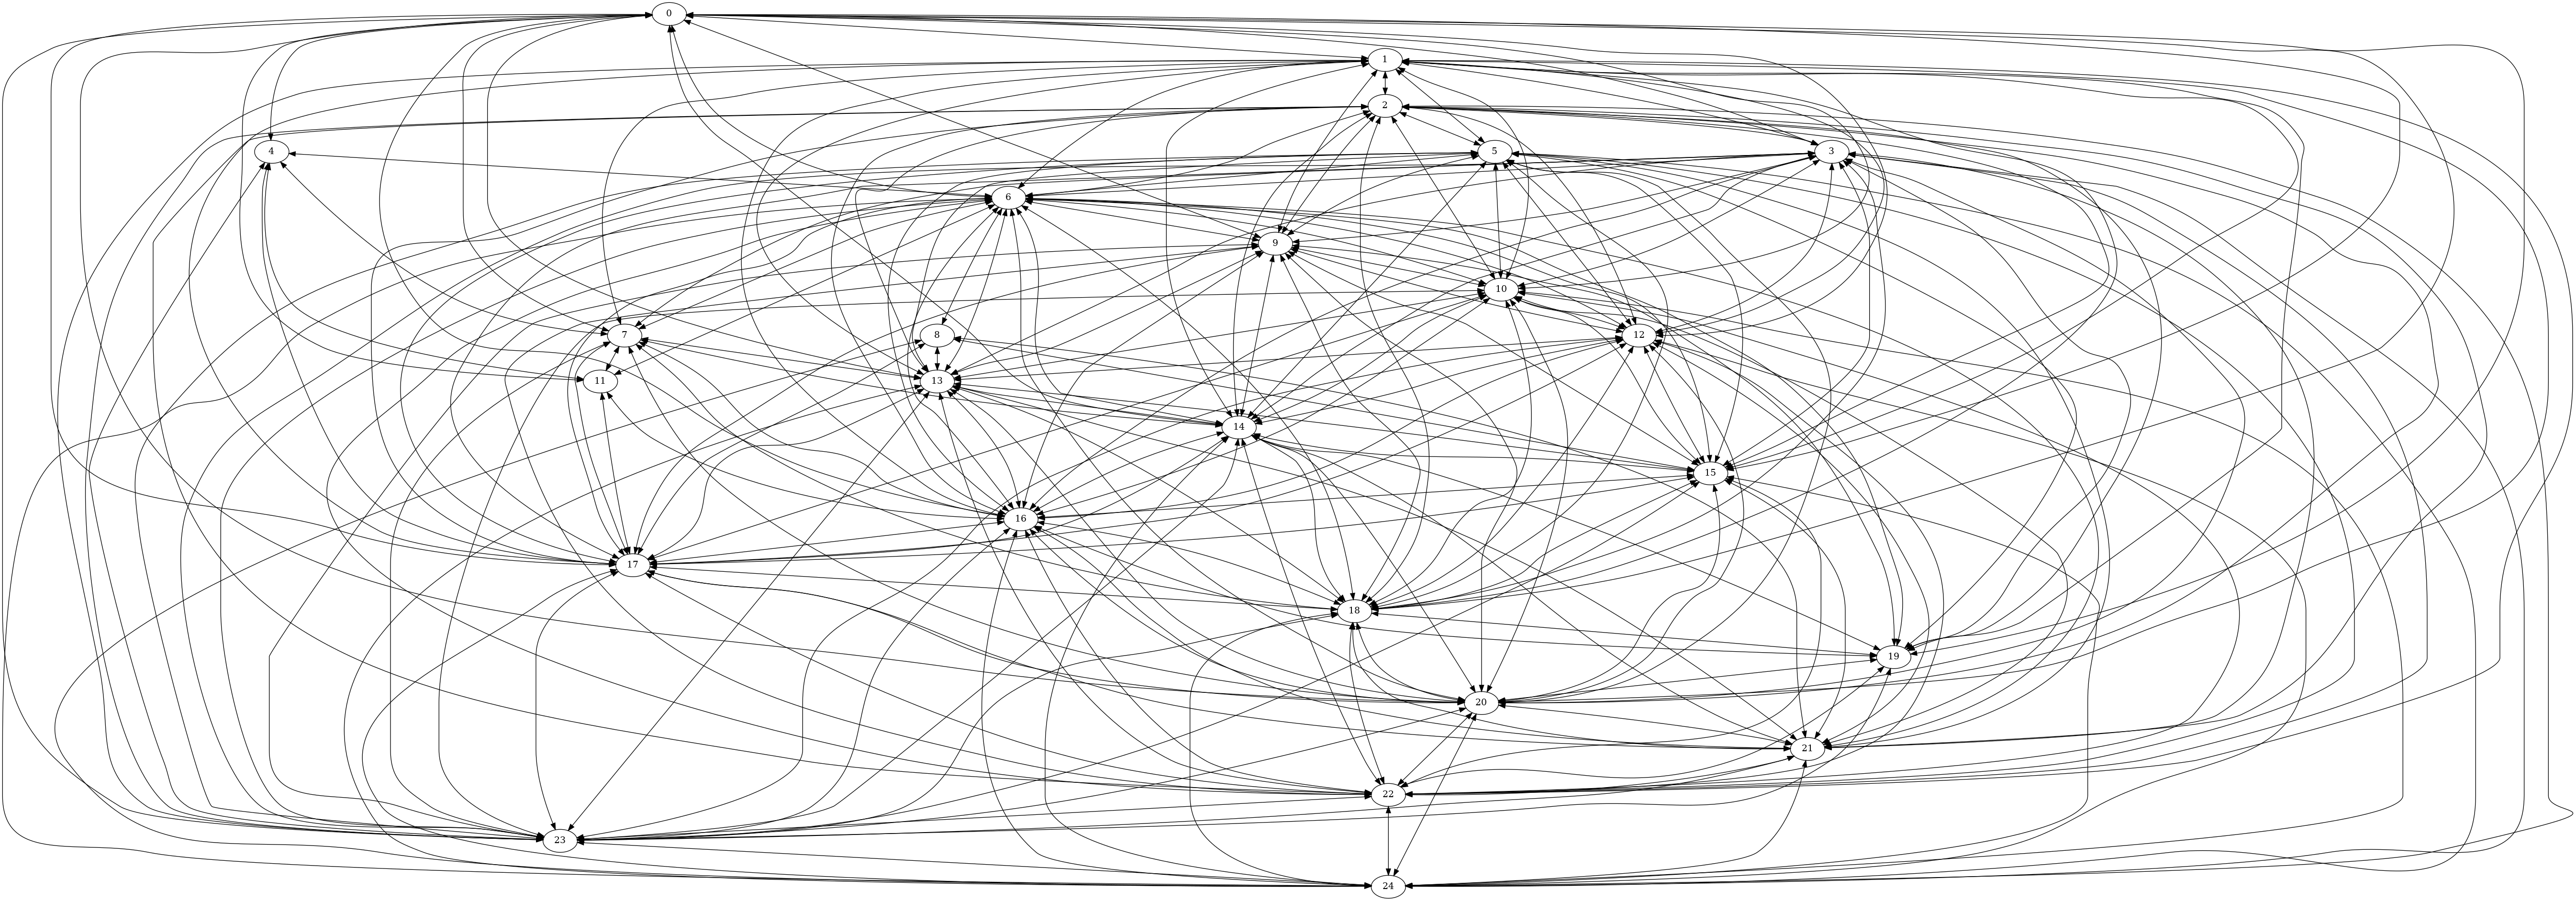

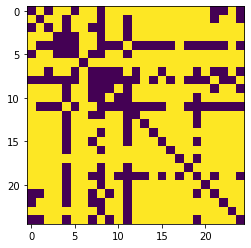

Graph has 1 connected components.


In [13]:
from util import notebook_plot_connectivity
notebook_plot_connectivity(regions, plot_dot=True, plot_adj_mat=True)

In [115]:
ORDER = order
gcs, flows_result = generate_flows(start, goal, ORDER, regions, dim=7)
print("flow generated")
start_vertex, end_vertex = prune(gcs, flows_result, epsilon=0.00001)
print("pruned")
best_path, best_rounded_result = run_dfs(flows_result, gcs, start_vertex, end_vertex, iterations=5)

INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 106 rounding trials with Mosek.


flow generated
Start vertex is  <pydrake.geometry.optimization.GraphOfConvexSets.Vertex object at 0x7251293437f0>   and end vertex is  <pydrake.geometry.optimization.GraphOfConvexSets.Vertex object at 0x72511d7bc230>
pruned
Cost for best path found   18.65713883817352


In [116]:
# # setup for PGD
variables, indices, h_list = generate_variable_list(best_path, ndim=7)
init_values = [best_rounded_result.GetSolution(x) for x in variables]
init_values.extend([best_rounded_result.GetSolution(h) for h in h_list])
init_values = np.asarray(init_values)

import numpy.linalg as la
# # iterate until infeasible.
# # get constraints and put into HPolyhedron - should be the same as 
prog, _ = prog_with_constraints(variables, best_path, start, goal, indices, 7, h_list)

In [117]:
print("program set")
hpoly = HPolyhedron(prog)
# is A necessary?
A = hpoly.A()
b = hpoly.b()
# create affine subspace
A_eq, b_eq = get_equality_matrices(prog)
U, S, V = la.svd(A_eq)

# nullspace is spanned by the last n-r columns of V
# rank is almost zero entries along the diagonal of S
r = (S>0.00001).sum()
basis = V[r:]
translation = la.pinv(A_eq).dot(b_eq)

affine_sub = AffineSubspace(basis.T, translation)

program set


## Running PGD

In [150]:
def get_step(values, indices, best_path, cost_func, gradient_func, step_size=0.01, backtracking=False, ndim=8):
    # R is a delay operator
    df_Rk = []
    last_common = 0
    f_Rk = 0
    for v in range(len(best_path[1:-1])):
        gradients = gradient_func(values[indices[v][0]:indices[v][1]])
#         print("Getting gradients")
        f_Rk += cost_func(values[indices[v][0]:indices[v][1]])
        if v==0:
            df_Rk.extend(gradients)
        else:
            for i in range(ndim):
                df_Rk[last_common-ndim+i] += gradients[i]
            df_Rk.extend(gradients[ndim:])
        last_common = len(df_Rk)
    df_Rk = np.asarray(df_Rk)
#     print("got initial gradients and costs ", f_Rk, df_Rk)

    f_k = 0
    t1 = 0
    t2 = 0
    L_norm = 0
    t = 0
    
    beta = 0.5
    # https://www.cs.cmu.edu/~ggordon/10725-F12/scribes/10725_Lecture5.pdf
    if backtracking:
        t = 0.1
        t1 = time.perf_counter()
        x_k = values - t * df_Rk
        f_k = 0 # TODO: FIX THIS
        for v in range(len(best_path[1:-1])):
            f_k += cost_func(x_k[indices[v][0]:indices[v][1]])
        L_norm = df_Rk.dot(df_Rk)
#         print("in backtracking, f_k determined to be ", f_k, "Max optimal is", (f_Rk - 0.5*t*(L_norm)))
#         print("in backtracking, while condition is ", f_k > (f_Rk - 0.5*t*(L_norm)))
        while f_k > (f_Rk - 0.5*t*(L_norm)):
            t = beta * t
            x_k = values - t * df_Rk
            f_k = 0
            for v in range(len(best_path[1:-1])):
                f_k += cost_func(x_k[indices[v][0]:indices[v][1]])
#             print("checkingwhat step to use f_k = ", f_k, "Will it work against ", f_Rk - 0.5*t*(L_norm))
            t2 = time.perf_counter()
        print('Found step size, ', t)

        return x_k, f_k, t2-t1, t, L_norm
    else:
        return df_Rk*step_size*-1, f_k, t2-t1, t, L_norm

In [151]:
t1_start = perf_counter() 
init_values = [best_rounded_result.GetSolution(x) for x in variables]
init_values.extend([best_rounded_result.GetSolution(h) for h in h_list])
init_values = np.asarray(init_values)
 
iters = 50
eps = 1e-7
qps_solved = 0
iter_costs = []
x_axis = []
times = []
t_grads = []
t_bt = []
t_qp = []
bt_costs = []
time_steps = []
lnorms = []
running_qp_project = []
termin = []
total_ts = []
costs_ts = []
qp, _ = prog_with_constraints(variables, best_path, start, goal, indices, 7, h_list)
init_values, qp_c = run_qp_proj(variables, init_values, best_path, start, goal, indices, h_list, qp)
print('setup')

setup


In [152]:
from jax import grad
import jax
# define costfn
jax.clear_caches()
costfn = jax.jit(distance_for_vertex, backend="gpu")
t1 = perf_counter()
costfn(init_values[indices[0][0]:indices[0][1]])
t2 = perf_counter()
print("warm start costfn took ", t2 - t1)

warm start costfn took  0.4397252859926084


In [153]:
q_star

array([0., 0., 0., 0., 0., 0., 0.])

In [154]:
grad_cost = grad(distance_for_vertex)
grad_jit = jax.jit(grad_cost, backend='gpu')
t1 = perf_counter()
grad_jit(init_values[indices[0][0]:indices[0][1]])
t2 = perf_counter()
t2 - t1

1.5332471919973614

In [160]:
investigative_trajs = []
exp_avg = 0
moving_avg = 0
diff_termin = []
window = 5
i = 0
while (len(diff_termin)==0 or abs(diff_termin[-1])>0.005) and i < 70:
    total_start = perf_counter()
    grad_time = perf_counter()
#     print('.')
#     bt_cost, bt_time, ts, l_norm = 0, 0, 0, 0
    print("old value", init_values)
    init_values[:len(variables)], bt_cost, bt_time, ts, l_norm = get_step(init_values[:len(variables)], indices, best_path, costfn, grad_jit, step_size=0.01, backtracking=True, ndim=7)
    print("EXPECTED COST", bt_cost)
    print("new value", init_values)
#     init_values[:len(variables)] = get_step(init_values[:len(variables)], indices, best_path, costfn, grad_jit, step_size=0.005, backtracking=False)
    grad_time_stop = perf_counter()
#     print(grad_time_stop - grad_time)
    #### NOT TIMED #####
    t_grads.append(grad_time_stop - grad_time)
    t_bt.append(bt_time)
    bt_costs.append(bt_cost)
    time_steps.append(ts)
    lnorms.append(l_norm)
    ## NOT TIMED FIN ##
    qp_time = perf_counter()
    cheap_proj = affine_sub.Projection(init_values)[1].T[0] # DOUBLE CHECK THE SHAPE OF THIS
    if not hpoly.PointInSet(cheap_proj):
        print("QP RUN")
        init_values, qp_c = run_qp_proj(variables, cheap_proj, best_path, start, goal, indices, h_list, qp, qp_c)
        qps_solved += 1
        running_qp_project.append(True)
    else:
        print("Cheap affine projection worked")
        init_values = cheap_proj
        running_qp_project.append(False)
    print("Post projection values", init_values)
    qp_time_stop = perf_counter()
    #### NOT TIMED #####
    t_qp.append(qp_time_stop - qp_time)
    cost = 0
    cost_calc_start = perf_counter()
    for v in range(len(best_path[1:-1])):
        cost += costfn(init_values[indices[v][0]:indices[v][1]])
        if cost!=cost:
            print(v, i)
    iter_costs.append(cost)
    if len(iter_costs) >= window:
        moving_avg_new = sum(iter_costs[-window:])/window
        termin.append(moving_avg_new)
        if moving_avg != 0:
            diff_termin.append((moving_avg_new - moving_avg)/moving_avg)
        moving_avg = moving_avg_new
#     exp_avg_new = alpha * cost + (1-alpha) * exp_avg
#     exp_avg = exp_avg_new
#     if len(iter_costs) > 4:
#         moving_avg_new = sum(iter_costs[-5:])/5
#         termin.append(moving_avg_new)
#         diff_termin.append((moving_avg_new - moving_avg)/moving_avg)
#         moving_avg = moving_avg_new
    cost_calc_stop = perf_counter()
    costs_ts.append(cost_calc_stop-cost_calc_start)
    x_axis.append(i)
    times.append(perf_counter()-t1_start)
    if i % 10 == 0:
#         qp, _ = prog_with_constraints(variables, best_path, start, goal, indices, h_list)
        print("     ")
    print('.', end='')
    ## NOT TIMED FIN ##
    total_end = perf_counter()
    total_ts.append(total_end-total_start)
    i += 1
#     if i>70:
#         investigative_trajs.append(trajectorify_given_vars(best_path, init_values, indices))
#     else if i==79:
        
t1_stop = perf_counter() 
cost = 0
for v in range(len(best_path[1:-1])):
    cost += costfn(init_values[indices[v][0]:indices[v][1]])
times.append(perf_counter()-t1_start)
iter_costs.append(cost)
x_axis.append(i)

print("Solve time:", t1_stop - t1_start, "QPs run", qps_solved, "iteration_costs", iter_costs)

old value [-0.62000592 -1.02963856  0.         -1.08251454  0.         -0.78414788
  0.         -0.35464448 -0.80028802  0.59923099 -0.83130752  0.61752441
 -0.46655507  0.9301473  -0.11610457 -0.54486166  1.59834672 -0.50156901
  1.6697082  -0.15014396  2.84408826 -0.11816324 -0.55846985  1.59586903
 -0.490427    1.6640582  -0.15344881  2.87092351 -0.12353489 -0.5238145
  1.58157572 -0.47429767  1.66153662 -0.19668427  2.88689399  0.56959496
 -0.11131222  5.82083168  0.46552775  5.84990081  0.85378159 10.03102228
  0.93159646  0.          8.23809275  0.93159646  8.23809275  1.55740772
 14.10141995  0.1         0.1       ]
Found step size,  0.1
EXPECTED COST 7.936249
new value [-0.59140679 -1.01680074  0.09537558 -1.06733279  0.09779568 -0.75499892
  0.13219498 -0.34195543 -0.79326558  0.60092322 -0.81808525  0.61836004
 -0.44947109  0.91888863 -0.10644916 -0.54257968  1.5963621  -0.48326536
  1.66709695 -0.13644219  2.8380964  -0.11004704 -0.55508012  1.59406614
 -0.47380474  1.661400

In [156]:
traj_pgd = trajectorify_given_vars(best_path, init_values, indices, ndim=7)
traj_og = trajectorify_given_vars(best_path, [best_rounded_result.GetSolution(x) for x in variables], indices, ndim=7)

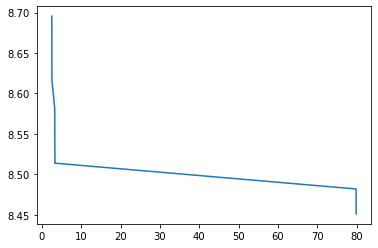

In [159]:
import matplotlib.pyplot as plt
plt.plot(times, iter_costs)

In [119]:
best_path

In [ ]:
from util import remap_and_toppra_trajectory, build_env, plot_traj_end_effector_path
from pydrake.all import MultibodyPositionToGeometryPose, TrajectorySource, Simulator
from analytic_ik import Analytic_IK_7DoF, iiwa_alpha, iiwa_d, iiwa_limits_lower, iiwa_limits_upper
analytic_ik = Analytic_IK_7DoF(iiwa_alpha, iiwa_d, iiwa_limits_lower, iiwa_limits_upper)

def remap(q):
    return 2*np.arctan(q)

gcs_traj = remap_and_toppra_trajectory(traj_pgd, remap, plant)

builder = DiagramBuilder()

subdiagram, plant, scene_graph = build_env(meshcat, directives_file, export_sg_input=True)
builder.AddNamedSystem("env_diagram", subdiagram)
pose_info = MultibodyPositionToGeometryPose(plant)
plot_traj_end_effector_path(gcs_traj, meshcat, )
to_pose = builder.AddSystem(pose_info)
builder.Connect(to_pose.get_output_port(), subdiagram.GetInputPort("source_pose"))

traj_system = builder.AddSystem(TrajectorySource(gcs_traj))
builder.Connect(traj_system.get_output_port(), to_pose.get_input_port())

diagram = builder.Build()

meshcat_visual = diagram.GetSubsystemByName("env_diagram").GetSystems()[1]

simulator = Simulator(diagram)
meshcat_visual.StartRecording()
simulator.AdvanceTo(gcs_traj.end_time() + 0.1)
meshcat_visual.PublishRecording()

In [ ]:
gcs_traj = remap_and_toppra_trajectory(traj, remap, plant)
breaks_new = np.linspace(0, gcs_traj.end_time(), int(1e3), endpoint=False)
knots_latent = traj.vector_values(breaks_new)

breaks_orig = np.linspace(0, traj.end_time(), int(1e3), endpoint=False)
knots_latent = traj.vector_values(breaks_orig)
knots_full = np.array([q_to_q_full(knot, FK_fun, analytic_ik) for knot in knots_latent.T]).T
gcs_traj = make_pl_traj(knots_full, speed=0.5)

# knots_full = gcs_traj.vector_values(breaks_new)

diagrams, plants = plot_traj_swept_volume(knots_full.T, build_env, meshcat, directives_file, count=2, alpha=0.15)
plot_traj_end_effector_path(knots_full.T,
                            meshcat,
                            analytic_ik)

meshcat.SetCameraPose([-1, 0.3825, 0.75], [0, 0.3825, 0.25])
render_trajectory(meshcat, build_env, directives_file, gcs_traj, save=True, fname="nonconvex_cost.html")

latent_traj_len = np.sum(np.linalg.norm(knots_latent[:,1:] - knots_latent[:,:-1], axis=0))
true_traj_len = np.sum(np.linalg.norm(knots_full[:,1:] - knots_full[:,:-1], axis=0))
print("GCS Latent Path Length: %f" % latent_traj_len)
print("GCS True Path Length: %f" % true_traj_len)

right_len = np.sum(np.linalg.norm(knots_full[7:,1:] - knots_full[7:,:-1], axis=0))
left_len = np.sum(np.linalg.norm(knots_full[:7,1:] - knots_full[:7,:-1], axis=0))
print(f"Arm 1 path length: {right_len}")
print(f"Arm 2 path length: {left_len}")
print(f"pretty metric: {(right_len-left_len)/left_len}")

reachability_errs = [reachability_constraint_violation(point[:7], point[7:], analytic_ik, FK_fun) for point in knots_full.T]
print("Maximum reachability distance error: %f" % np.max(reachability_errs))
plt.plot(reachability_errs)
plt.show()

with open(RepoDir() + "/data/q_full_path.pickle", "wb") as f:
    pickle.dump(knots_full.T, f)

In [ ]:
len(best_path)

In [ ]:
# dumb init
pts = np.squeeze(np.array([np.arctan(traj.value(it * traj.end_time() / 100)) for it in range(100)]))

In [ ]:
# np.hstack([pts, 0 * np.ones((pts.shape[0], 3 - pts.shape[1]))]).T
pts.shape

In [98]:
# # visualize path given trajectory
import visualization_utils as viz_utils
# viz_utils.draw_traj(visualizer.meshcat_cspace, traj, 100)
# viz_utils.draw_nontc_traj(visualizer.meshcat_nontc, traj, 100, q_star=q_star)
# visualizer.animate_traj_s(traj, 100, 100)
viz_utils.draw_traj(visualizer.meshcat_cspace, traj_og, 100)
viz_utils.draw_nontc_traj(visualizer.meshcat_nontc, traj_og, 100, q_star=q_star)
visualizer.animate_traj_s(traj_og, 100, 100)
viz_utils.draw_traj(visualizer.meshcat_cspace, traj_pgd, 100)
viz_utils.draw_nontc_traj(visualizer.meshcat_nontc, traj_pgd, 100, q_star=q_star)
visualizer.animate_traj_s(traj_pgd, 100, 100)

## Validating Paths?

In [106]:
# take a path
# calculate the q value at each point along the trajectory
# Sum all of them
def length_of_traj(traj):
    q_prev = start_q
    dist = 0
    for i in range(50):
        s = traj.value(traj.end_time()*i/50)
        q = Ratfk.ComputeQValue(s, q_star)
        dist += ((q - q_prev).dot(q - q_prev))**0.5
        q_prev = q
    return dist
new_len = length_of_traj(traj_pgd)
og_len = length_of_traj(traj_og)
print(new_len, og_len)

7.54364600906225 8.641229878292995


In [107]:
(og_len - new_len) / og_len

0.12701708954507795

In [108]:
q_star

array([0., 0., 0., 0., 0., 0., 0.])

In [109]:
traj_og.end_time()

2.0

In [110]:
traj_pgd.end_time()

2.0

In [56]:
iter_dist = 0
values = init_values
for v in range(len(best_path[1:-1])):
    iter_dist += distance_for_vertex(values[indices[v][0]:indices[v][1]])

In [57]:
iter_dist

Array(3.3586519, dtype=float32)

In [58]:
iter_dist = 0
values = [best_rounded_result.GetSolution(x) for x in variables]
for v in range(len(best_path[1:-1])):
    iter_dist += distance_for_vertex(values[indices[v][0]:indices[v][1]])

In [59]:
iter_dist

Array(3.3597455, dtype=float32)

In [99]:
q_star

array([1., 1.])

## 7 DOF IIWA

In [5]:
#construct our robot
builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.001)
parser = Parser(plant)

parser.package_map().Add("ciris_pgd", os.path.abspath(''))

directives_file = "/home/sgrg/rlg/SUPERUROP/ciris/models/iiwa14_sphere_collision_complex_scenario.dmd.yaml"
directives = LoadModelDirectives(directives_file)
models = ProcessModelDirectives(directives, plant, parser)


# oneDOF_iiwa_file = "/home/sgrg/rlg/SUPERUROP/ciris/assets/oneDOF_iiwa7_with_box_collision.sdf"
# with open(one|DOF_iiwa_file, 'r') as f:
#     oneDOF_iiwa_string = f.read()
# box_asset_file = "/home/sgrg/rlg/SUPERUROP/ciris/assets/box_small.urdf"
# with open(box_asset_file, 'r') as f:
#     box_asset_string = f.read()